## DS 5110: Big Data Systems
# Final Project: Netflix Recommender System & Ratings Predictions
### Primary (Consolidated) Code File
#### Lauren Neal (ln9bv) | Melanie Sattler (ms9py) | Nick Thompson (nat3fa) | Nima Beheshti (nb9pp)

In [9]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## to assess time taken to train models
from datetime import datetime
%matplotlib inline

# Exploratory Data Analysis

In [11]:
df_eda = pd.read_csv("movies_addtl_features.csv")
df_eda.describe()

,id,year,Runtime,Rating
count,17769.000000,17762.000000,11742.000000,11964.000000
mean,8885.635151,1990.263484,103.903083,6.521481
std,5130.014196,16.508332,49.381879,1.224427
min,1.000000,1896.000000,3.000000,1.400000
25%,4443.000000,1985.000000,89.000000,5.800000
50%,8886.000000,1997.000000,98.000000,6.700000
75%,13328.000000,2002.000000,113.000000,7.400000
max,17770.000000,2005.000000,1620.000000,9.500000


In [12]:
df_eda[df_eda['Runtime'] == 1620.000000]

,id,year,title,Runtime,Rating,Directors,Writers,Production companies,Genres
9567,9569,1988.0,War and Remembrance: Vol. 2,1620.0,8.3,Dan Curtis,Dan Curtis-Earl W. Wallace-Herman Wouk,Dan Curtis Productions-ABC Circle Films-Jadran...,Drama-War
15909,15911,1988.0,War and Remembrance: Vol. 1,1620.0,8.3,Dan Curtis,Dan Curtis-Earl W. Wallace-Herman Wouk,Dan Curtis Productions-ABC Circle Films-Jadran...,Drama-War


In [13]:
df_eda[df_eda['Rating'] == 9.500000]

,id,year,title,Runtime,Rating,Directors,Writers,Production companies,Genres
15294,15296,2001.0,Band of Brothers,594.0,9.5,David Frankel-Mikael Salomon-Tom Hanks,Stephen Ambrose-Erik Bork-E. Max Frye,DreamWorks-DreamWorks Television-HBO Films-Pla...,Action-Drama-History-War


<AxesSubplot:xlabel='year'>

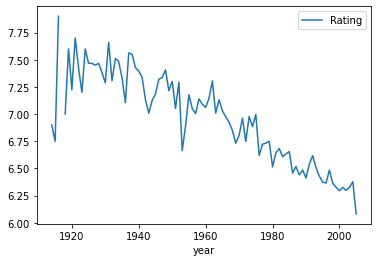

In [17]:
gbyear = df_eda.groupby("year").mean()
gbyear.plot.line(y='Rating')

<AxesSubplot:xlabel='Runtime'>

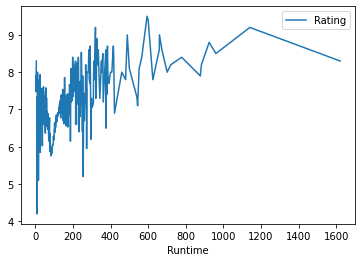

In [18]:
gbrt = df_eda.groupby("Runtime").mean()
gbrt.plot.line(y='Rating')

<AxesSubplot:xlabel='Runtime'>

<Figure size 432x288 with 0 Axes>

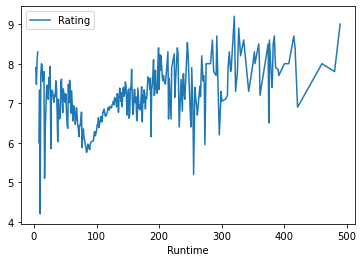

In [19]:
gbrt = df_eda[df_eda["Runtime"] < 500].groupby("Runtime").mean()
plt.figure()
gbrt.plot.line(y='Rating')

<AxesSubplot:xlabel='Genres'>

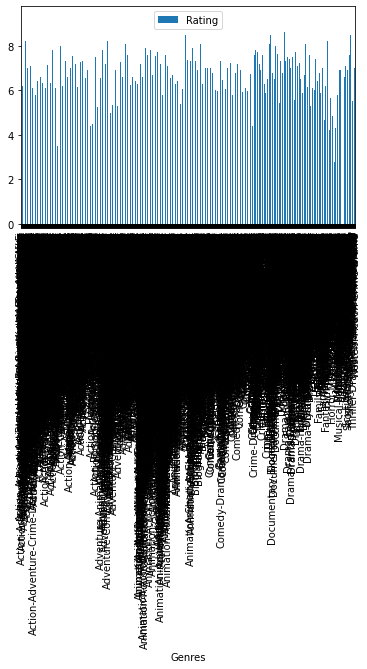

In [20]:
# This was a horrible mess of a diagram, so we take a different approach to visualize this
gbyear = df_eda.groupby("Genres").mean()
gbyear.plot.bar(y='Rating')

<AxesSubplot:xlabel='numGenres'>

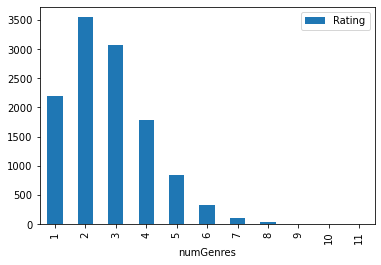

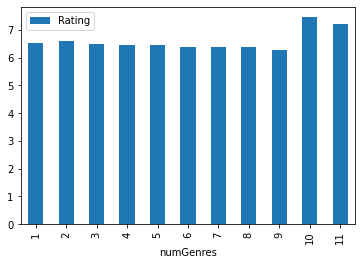

In [21]:
dfdrop = df_eda.dropna(subset=['Genres'], inplace=False)
dfdrop = dfdrop.dropna(subset=['Rating'], inplace=False)

## since genres all appear in the same column, separated by a dash, we need to parse them

dfdrop["numGenres"] = dfdrop.apply(lambda row: len(row['Genres'].split("-")), axis=1)
gbnumGen = dfdrop.groupby("numGenres").count()
gbnumGen.plot.bar(y='Rating')
gbnumGen = dfdrop.groupby("numGenres").mean()
gbnumGen.plot.bar(y='Rating')

### Creating a Dictionary of Average Rating by Genre

In [22]:
genreDict = {}
for index, row in dfdrop.iterrows():
    rating = row['Rating']
    allGenres = row['Genres'].split("-")
    for genre in allGenres:
        if genre in genreDict:
            genreDict[genre].append(rating)
        else:
            genreDict[genre] = [rating]

In [23]:
for key in genreDict:
    genreDict[key] = sum(genreDict[key])/len(genreDict[key])

genreDict = dict(sorted(genreDict.items(), key=lambda item: item[1]))

for key in genreDict:
    print(key + ": \t\t" + str(genreDict[key]))

Horror: 		5.470573139435416
Sci: 		6.040660295395313
Fi: 		6.040660295395313
Action: 		6.1044922788956315
Thriller: 		6.135338645418321
Reality: 		6.253571428571428
TV: 		6.253571428571428
Fantasy: 		6.315254237288134
Comedy: 		6.324409448818888
Family: 		6.400380952380956
Adventure: 		6.405750165234629
Game: 		6.44
Crime: 		6.5184909670563185
Romance: 		6.568319045844208
Sport: 		6.622128851540621
Mystery: 		6.630985915492959
Musical: 		6.648915187376726
Western: 		6.679503105590067
Drama: 		6.701140619679947
Animation: 		6.904029850746272
War: 		7.0721541155866925
Short: 		7.1222222222222245
Biography: 		7.1606779661016935
Show: 		7.190909090909091
History: 		7.2683467741935415
Music: 		7.328996282527873
Film: 		7.3979797979798
Noir: 		7.3979797979798
Documentary: 		7.411469534050167
Talk: 		7.816666666666666


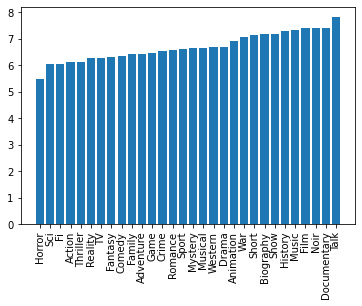

In [24]:
keys = genreDict.keys()
vals = genreDict.values()
plt.bar(keys, vals)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

In [26]:
spark = SparkSession.builder.getOrCreate()
file_1 = 'combined_data_1.txt'
file_2 = 'combined_data_2.txt'
file_3 = 'combined_data_3.txt'
file_4 = 'combined_data_4.txt'

movie_title_file = 'movie_titles.csv'
movie_add_feat = 'movies_addtl_features.csv'

In [27]:
df_file_1 = spark.read.text(file_1)
df_file_2 = spark.read.text(file_2)
df_file_3 = spark.read.text(file_3)
df_file_4 = spark.read.text(file_4)

In [28]:
df_file_1 = df_file_1.withColumn("viewer_id", split(df_file_1["value"], ",").getItem(0)).withColumn("rating", split(df_file_1["value"], ",").getItem(1)).withColumn("date_viewed", split(df_file_1["value"], ",").getItem(2))
df_file_1 = df_file_1.drop(df_file_1['value'])
df_file_2 = df_file_2.withColumn("viewer_id", split(df_file_2["value"], ",").getItem(0)).withColumn("rating", split(df_file_2["value"], ",").getItem(1)).withColumn("date_viewed", split(df_file_2["value"], ",").getItem(2))
df_file_2 = df_file_2.drop(df_file_2['value'])
df_file_3 = df_file_3.withColumn("viewer_id", split(df_file_3["value"], ",").getItem(0)).withColumn("rating", split(df_file_3["value"], ",").getItem(1)).withColumn("date_viewed", split(df_file_3["value"], ",").getItem(2))
df_file_3 = df_file_3.drop(df_file_3['value'])
df_file_4 = df_file_4.withColumn("viewer_id", split(df_file_4["value"], ",").getItem(0)).withColumn("rating", split(df_file_4["value"], ",").getItem(1)).withColumn("date_viewed", split(df_file_4["value"], ",").getItem(2))
df_file_4 = df_file_4.drop(df_file_4['value'])

The table produced via te following code cell demonstrates the particular challenges of working with these data files -- the `Movie_ID` was included as a row in the `viewer_id` column, followed by a colon.

In [30]:
df_concat = df_file_1.union(df_file_2)
df_concat = df_concat.union(df_file_3)
df_concat = df_concat.union(df_file_4)
df_concat.show()

+---------+------+-----------+
|viewer_id|rating|date_viewed|
+---------+------+-----------+
|       1:|  null|       null|
|  1488844|     3| 2005-09-06|
|   822109|     5| 2005-05-13|
|   885013|     4| 2005-10-19|
|    30878|     4| 2005-12-26|
|   823519|     3| 2004-05-03|
|   893988|     3| 2005-11-17|
|   124105|     4| 2004-08-05|
|  1248029|     3| 2004-04-22|
|  1842128|     4| 2004-05-09|
|  2238063|     3| 2005-05-11|
|  1503895|     4| 2005-05-19|
|  2207774|     5| 2005-06-06|
|  2590061|     3| 2004-08-12|
|     2442|     3| 2004-04-14|
|   543865|     4| 2004-05-28|
|  1209119|     4| 2004-03-23|
|   804919|     4| 2004-06-10|
|  1086807|     3| 2004-12-28|
|  1711859|     4| 2005-05-08|
+---------+------+-----------+
only showing top 20 rows



In [31]:
df_concat.count()

100498277

In [32]:
df_concat = df_concat.withColumn("viewer_id",df_concat["viewer_id"].cast(IntegerType()))
df_concat = df_concat.withColumn("rating",df_concat["rating"].cast(IntegerType()))
agg_df = df_concat.groupBy('viewer_id').agg(f.count("viewer_id"))
agg_df.show()

+---------+----------------+
|viewer_id|count(viewer_id)|
+---------+----------------+
|  1774623|            1477|
|  2151149|              91|
|  2446687|              50|
|  2427438|             318|
|  2496050|             887|
|  1377693|            1148|
|  2190625|            1340|
|  1560852|             281|
|  1608536|             315|
|  1081461|             454|
|   624145|            1176|
|   415982|             234|
|   340002|             101|
|  2591081|             490|
|  2038778|            1181|
|   755939|            1230|
|    75120|             484|
|   358664|              35|
|    64423|             168|
|   811782|             305|
+---------+----------------+
only showing top 20 rows



In [33]:
agg_df.describe('count(viewer_id)').show()

+-------+------------------+
|summary|  count(viewer_id)|
+-------+------------------+
|  count|            480190|
|   mean|209.25156084050064|
| stddev|  302.338991474441|
|    min|                 0|
|    max|             17653|
+-------+------------------+



In [34]:
df_additional = pd.read_csv("movies_addtl_features.csv")


<AxesSubplot:>

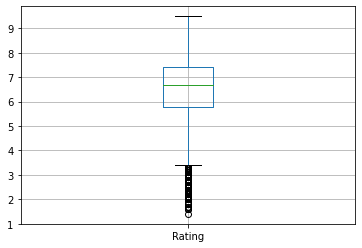

In [35]:
boxplot_rating = df_additional.boxplot(column=['Rating'])
boxplot_rating

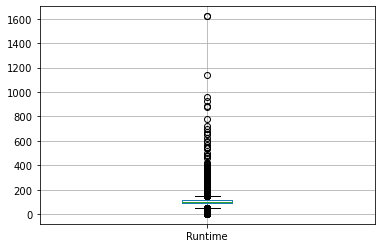

In [36]:
boxplot_Runtime = df_additional.boxplot(column=['Runtime'])


<AxesSubplot:>

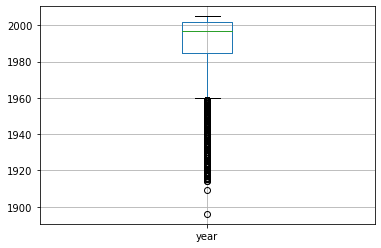

In [37]:
boxplot_year = df_additional.boxplot(column=['year'])
boxplot_year 

In [38]:
dfdrop_director = df_additional.dropna(subset=['Directors'], inplace=False)
dfdrop_director = dfdrop_director.dropna(subset=['Rating'], inplace=False)

### Creating a Dictionary of Average Rating by Director

In [39]:
#looking at the different directors and their ratings for each of their movies in this list 
DirectorDict = {}
for index, row in dfdrop_director.iterrows():
    rating = row['Rating']
    allDirectors = row['Directors'].split("-")
    for director in allDirectors:
        if director in DirectorDict:
            DirectorDict[director].append(rating)
        else:
            DirectorDict[director] = [rating]

In [40]:
#getting the average score for each of the directors 
avgDirectorDict = {}
for k,v in DirectorDict.items():
    # v is the list of ratings for Director stored in k
    avgDirectorDict[k] = sum(v)/ float(len(v))

In [42]:
#sorting the average rating values for the Directors 
sorted_values_avgDirector = sorted(avgDirectorDict.values()) # Sort the values
sorted_dict_avgDirector = {}

for i in sorted_values_avgDirector:
    for k in avgDirectorDict.keys():
        if avgDirectorDict[k] == i:
            sorted_dict_avgDirector[k] = avgDirectorDict[k]
            break

In [43]:
import random    
sample_n = 20
output_avgdir_dict = dict(random.sample(sorted_dict_avgDirector.items(), sample_n))
output_avgdir_dict

{'Andrew Green': 2.3,
 'Brett Ratner': 6.614285714285715,
 'John Pasquin': 5.666666666666667,
 'Robert Z. Leonard': 6.966666666666668,
 'Mark Rydell': 6.622222222222221,
 'Tyler Perry': 4.1000000000000005,
 'Roger Young': 6.288888888888889,
 'Ringo Lam': 6.2444444444444445,
 'Edward Zwick': 7.033333333333332,
 'Arthur Hiller': 6.6625,
 'Lawrence Jordan': 7.945454545454546,
 'Howard Deutch': 6.518181818181817,
 'Claude Chabrol': 7.17,
 'Mimi Leder': 6.433333333333334,
 'Emile Ardolino': 6.428571428571428,
 'Forest Whitaker': 6.133333333333333,
 'Stanley Donen': 6.807692307692307,
 'Steven Soderbergh': 6.781818181818181,
 'Todd Phillips': 7.019999999999999,
 'Orson Welles': 7.840000000000001}

In [44]:
dfdrop_writer = df_additional.dropna(subset=['Writers'], inplace=False)
dfdrop_writer = dfdrop_writer.dropna(subset=['Rating'], inplace=False)

### Creating a Dictionary of Average Rating by Screenwriter

In [45]:
#looking at the writers directors and their ratings for each of their movies in this list 
WriterDict = {}
for index, row in dfdrop_writer.iterrows():
    rating = row['Rating']
    allWriter = row['Writers'].split("-")
    for writer in allWriter:
        if writer in WriterDict:
            WriterDict[writer].append(rating)
        else:
            WriterDict[writer] = [rating]

In [46]:
#getting the average score for each of the writers 
avgWriterDict = {}
for k,v in WriterDict.items():
    # v is the list of ratings for Director stored in k
    avgWriterDict[k] = sum(v)/ float(len(v))

In [47]:
#sorting the avergae ratings for each fo the writers 
sorted_values_avgWriter = sorted(avgWriterDict.values()) # Sort the values
sorted_dict_avgWriter = {}

for i in sorted_values_avgWriter:
    for k in avgWriterDict.keys():
        if avgWriterDict[k] == i:
            sorted_dict_avgWriter[k] = avgWriterDict[k]
            break

In [48]:
output_avgwrit_dict = dict(random.sample(sorted_dict_avgWriter.items(), sample_n))
output_avgwrit_dict

{'Tony Gilroy': 6.8625,
 'Ernest K. Gann': 6.659999999999999,
 'François Ozon': 6.985714285714287,
 'Michael J. Nelson': 8.07272727272727,
 'Ryo Mizuno': 7.033333333333334,
 'Jerry Juhl': 7.12,
 'Wendell Mayes': 7.2333333333333325,
 'Stanley Shapiro': 6.9125,
 'Jirô Kuwata': 5.0,
 'Nat Mauldin': 5.550000000000001,
 'Tullio Pinelli': 7.616666666666666,
 'Roderick Taylor': 6.08,
 'Andy Hurst': 4.175,
 'H.E. Bates': 6.94,
 'Matthew Gissing': 5.033333333333334,
 'Bob Fosse': 7.233333333333333,
 'Georges Chaperot': 7.9,
 'Nora Ephron': 6.127272727272728,
 'Georges Clouzot': 7.316666666666666,
 'Michael Swerdlick': 5.340000000000001}

# Data Import & Preprocessing

In [95]:
df_file1 = pd.read_csv('combined_data_1.txt', 
                       header = None, 
                       names=['user_id','rating'], 
                       usecols=[0,1])

print('combined_data_1.txt file details:')
print(df_file1.shape)
print(' ')
print("First 5 rows")
print(df_file1.head(5))
print(' ')


df_file2 = pd.read_csv('combined_data_2.txt', 
                       header = None, 
                       names=['user_id','rating'], 
                       usecols=[0,1])

print('combined_data_2.txt file details:')
print(df_file2.shape)
print(' ')
print("First 5 rows")
print(df_file2.head(5))
print(' ')

df_file3 = pd.read_csv('combined_data_3.txt', 
                       header = None, 
                       names=['user_id','rating'], 
                       usecols=[0,1])

print('combined_data_3.txt file details:')
print(df_file3.shape)
print(' ')
print("First 5 rows")
print(df_file3.head(5))
print(' ')

df_file4 = pd.read_csv('combined_data_4.txt', 
                       header = None, 
                       names=['user_id','rating'], 
                       usecols=[0,1])

print('combined_data_4.txt file details:')
print(df_file4.shape)
print(' ')
print("First 5 rows")
print(df_file4.head(5))

combined_data_1.txt file details:
(24058263, 2)
 
First 5 rows
   user_id  rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0
 
combined_data_2.txt file details:
(26982302, 2)
 
First 5 rows
   user_id  rating
0    4500:     NaN
1  2532865     4.0
2   573364     3.0
3  1696725     3.0
4  1253431     3.0
 
combined_data_3.txt file details:
(22605786, 2)
 
First 5 rows
   user_id  rating
0    9211:     NaN
1  1277134     1.0
2  2435457     2.0
3  2338545     3.0
4  2218269     1.0
 
combined_data_4.txt file details:
(26851926, 2)
 
First 5 rows
   user_id  rating
0   13368:     NaN
1  2385003     4.0
2   659432     3.0
3   751812     2.0
4  2625420     2.0


#### Processing the First File (Moving `movie_id` Out of `user_id` Column & Into its Own)

In [96]:
## create dataframe including only observations with null values
## this effectively isolates the rows containing only movie IDs (as they have no entries in the rating or date columns)
df_nan_1 = pd.DataFrame(pd.isnull(df_file1.rating))
df_nan_1 = df_nan_1[df_nan_1['rating']==True]

## shape will print number of total movie IDs contained in this single file
print(df_nan_1.shape)

## create empty array to store movie IDs
movie_np_1 = []

## note first movie ID that appears in the file
movie_id_1 = 1

for i,j in zip(df_nan_1.index[1:], df_nan_1.index[:-1]):
    temp_arr_1 = np.full((1,i-j-1), movie_id_1)
    movie_np_1 = np.append(movie_np_1,temp_arr_1)
    movie_id_1 += 1

q1 = np.full((1,len(df_file1) - df_nan_1.index[-1] -1), movie_id_1)
movie_np_1 = np.append(movie_np_1,q1)
print(len(movie_np_1))

(4499, 1)
24053764


In [98]:
## now handling remaining observations (numerous rating and by which user)
df_file1 = df_file1[pd.notnull(df_file1['rating'])]

## create movie_id column out of movie ID numpy array
df_file1['movie_id'] = movie_np_1.astype(int)
df_file1['user_id'] = df_file1['user_id'].astype(int)
print(df_file1.columns)

print(df_file1.iloc[::5000000,:])

new_cols = df_file1.columns.tolist()
new_cols = new_cols[:1]+new_cols[-1:]+new_cols[1:2]
df_file1 = df_file1[new_cols]

df_file1.to_csv("processed_pt1.txt", encoding='utf-8', index=False)

Index(['user_id', 'movie_id', 'rating'], dtype='object')
          user_id  movie_id  rating
1         1488844         1     3.0
5000996    501954       996     2.0
10001962   404654      1962     5.0
15002876   886608      2876     2.0
20003825  1193835      3825     2.0


In [99]:
df_file1.head()

,user_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


#### Processing the Second File (Moving `movie_id` Out of `user_id` Column & Into its Own)

In [100]:
## create dataframe including only observations with null values
## this effectively isolates the rows containing only movie IDs (as they have no entries in the rating or date columns)
df_nan_2 = pd.DataFrame(pd.isnull(df_file2.rating))
df_nan_2 = df_nan_2[df_nan_2['rating']==True]

## shape will print number of total movie IDs contained in this single file
print(df_nan_2.shape)

## create empty array to store movie IDs
## note first movie ID that appears in the file
movie_np_2 = []
movie_id_2 = 4500

for i,j in zip(df_nan_2.index[1:],df_nan_2.index[:-1]):
    temp_arr_2 = np.full((1,i-j-1), movie_id_2)
    movie_np_2 = np.append(movie_np_2,temp_arr_2)
    movie_id_2 += 1

print(df_nan_2.iloc[-1, 0])

q2 = np.full((1,len(df_file2) - df_nan_2.index[-1] -1), movie_id_2)

movie_np_2 = np.append(movie_np_2,q2)
print(len(movie_np_2))

(4711, 1)
True
26977591


In [102]:
## now handling remaining observations (numerous rating and by which user)
df_file2 = df_file2[pd.notnull(df_file2['rating'])]

## create movie_id column out of movie ID numpy array
df_file2['movie_id'] = movie_np_2.astype(int)
df_file2['user_id'] = df_file2['user_id'].astype(int)
print(df_file2.columns)

print(df_file2.iloc[::5000000,:])

new_cols_2 = df_file2.columns.tolist()
new_cols_2 = new_cols_2[:1]+new_cols_2[-1:]+new_cols_2[1:2]
df_file2 = df_file2[new_cols_2]

df_file2.to_csv("processed_pt2.txt", encoding='utf-8', index=False)

Index(['user_id', 'rating', 'movie_id'], dtype='object')
          user_id  rating  movie_id
1         2532865     4.0      4500
5000819    775559     2.0      5318
10001635  2366877     4.0      6134
15002436  1579371     4.0      6935
20003268  1427824     5.0      7767
25004333   768518     4.0      8832


In [103]:
df_file2.head()

,user_id,movie_id,rating
1,2532865,4500,4.0
2,573364,4500,3.0
3,1696725,4500,3.0
4,1253431,4500,3.0
5,1265574,4500,2.0


#### Processing the Third File (Moving `movie_id` Out of `user_id` Column & Into its Own)

In [104]:
## create dataframe including only observations with null values
## this effectively isolates the rows containing only movie IDs (as they have no entries in the rating or date columns)
df_nan_3 = pd.DataFrame(pd.isnull(df_file3.rating))
df_nan_3 = df_nan_3[df_nan_3['rating']==True]

## shape will print number of total movie IDs contained in this single file
print(df_nan_3.shape)

## create empty array to store movie IDs
## note first movie ID that appears in the file
movie_np_3 = []
movie_id_3 = 9211

for i,j in zip(df_nan_3.index[1:],df_nan_3.index[:-1]):
    temp_arr_3 = np.full((1,i-j-1), movie_id_3)
    movie_np_3 = np.append(movie_np_3,temp_arr_3)
    movie_id_3 += 1

print(df_nan_3.iloc[-1, 0])

q3 = np.full((1,len(df_file3) - df_nan_3.index[-1] -1), movie_id_3)
movie_np_3 = np.append(movie_np_3,q3)
print(len(movie_np_3))

(4157, 1)
True
22601629


In [105]:
## now handling remaining observations (numerous rating and by which user)
df_file3 = df_file3[pd.notnull(df_file3['rating'])]

## create movie_id column out of movie ID numpy array
df_file3['movie_id'] = movie_np_3.astype(int)
df_file3['user_id'] = df_file3['user_id'].astype(int)
print(df_file3.columns)

print(df_file3.iloc[::5000000,:])

new_cols_3 = df_file3.columns.tolist()
new_cols_3 = new_cols_3[:1]+new_cols_3[-1:]+new_cols_3[1:2]
df_file3 = df_file3[new_cols_3]

df_file3.to_csv("processed_pt3.txt", encoding='utf-8', index=False)

Index(['user_id', 'rating', 'movie_id'], dtype='object')
          user_id  rating  movie_id
1         1277134     1.0      9211
5001019    361439     4.0     10229
10001942   488142     5.0     11152
15002874  1572917     4.0     12084
20003671   550725     3.0     12881


In [106]:
df_file3.head()

,user_id,movie_id,rating
1,1277134,9211,1.0
2,2435457,9211,2.0
3,2338545,9211,3.0
4,2218269,9211,1.0
5,441153,9211,4.0


#### Processing the Fourth File (Moving `movie_id` Out of `user_id` Column & Into its Own)

In [107]:
## create dataframe including only observations with null values
## this effectively isolates the rows containing only movie IDs (as they have no entries in the rating or date columns)
df_nan_4 = pd.DataFrame(pd.isnull(df_file4.rating))
df_nan_4 = df_nan_4[df_nan_4['rating']==True]

## shape will print number of total movie IDs contained in this single file
print(df_nan_4.shape)

## create empty array to store movie IDs
## note first movie ID that appears in the file
movie_np_4 = []
movie_id_4 = 13368

for i,j in zip(df_nan_4.index[1:],df_nan_4.index[:-1]):
    temp_arr_4 = np.full((1,i-j-1), movie_id_4)
    movie_np_4 = np.append(movie_np_4,temp_arr_4)
    movie_id_4 += 1

# last movie id

print(df_nan_4.iloc[-1, 0])

q4 = np.full((1,len(df_file4) - df_nan_4.index[-1] -1), movie_id_4)
movie_np_4 = np.append(movie_np_4,q4)
print(len(movie_np_4))

(4403, 1)
True
26847523


In [108]:
## now handling remaining observations (numerous rating and by which user)
df_file4 = df_file4[pd.notnull(df_file4['rating'])]

## create movie_id column out of movie ID numpy array
df_file4['movie_id'] = movie_np_4.astype(int)
df_file4['user_id'] = df_file4['user_id'].astype(int)
print(df_file4.columns)

print(df_file4.iloc[::5000000,:])

new_cols_4 = df_file4.columns.tolist()
new_cols_4 = new_cols_4[:1]+new_cols_4[-1:]+new_cols_4[1:2]
df_file4 = df_file4[new_cols_4]

df_file4.to_csv("processed_pt4.txt", encoding='utf-8', index=False)

Index(['user_id', 'rating', 'movie_id'], dtype='object')
          user_id  rating  movie_id
1         2385003     4.0     13368
5000907    495207     1.0     14274
10001561  2243515     4.0     14928
15002391  2210687     5.0     15758
20003238  2088300     5.0     16605
25004038   717559     3.0     17405


In [109]:
df_file4.head()

,user_id,movie_id,rating
1,2385003,13368,4.0
2,659432,13368,3.0
3,751812,13368,2.0
4,2625420,13368,2.0
5,1650301,13368,1.0


### Combining Each File's Corresponding Dataframe into a Single DF Containing All Ratings

In [110]:
df_all = df_file1.append(df_file2, ignore_index=True)
df_all = df_all.append(df_file3, ignore_index=True)
df_all = df_all.append(df_file4, ignore_index=True)

In [111]:
df_all.describe()

,user_id,rating,movie_id
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,1.322489e+06,3.604290e+00,9.070915e+03
std,7.645368e+05,1.085219e+00,5.131891e+03
min,6.000000e+00,1.000000e+00,1.000000e+00
25%,6.611980e+05,3.000000e+00,4.677000e+03
50%,1.319012e+06,4.000000e+00,9.051000e+03
75%,1.984455e+06,4.000000e+00,1.363500e+04
max,2.649429e+06,5.000000e+00,1.777000e+04


In [112]:
df_all.head()

,user_id,rating,movie_id
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1


## Creating our Base Dataset File (with all ratings for all films included)

In [113]:
df_all.to_csv("processed_all.txt", encoding='utf-8', index=False)

In [10]:
## reordering columns
reorder_columns = pd.read_csv("processed_all.txt")
reorder_columns.head()

,user_id,rating,movie_id
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1


In [11]:
reorder_columns = reorder_columns[['user_id', 'movie_id', 'rating']]
reorder_columns.head()

,user_id,movie_id,rating
0,1488844,1,3.0
1,822109,1,5.0
2,885013,1,4.0
3,30878,1,4.0
4,823519,1,3.0


In [12]:
reorder_columns.to_csv("processed_all_2.txt", encoding='utf-8', index=False)

In [115]:
df_extra = pd.read_csv('movies_addtl_features.csv')
print('Additional features data summary')
print(df_extra.shape)
print(' ')
print("First 5 rows")
print(df_extra.head())

Additional features data summary
(17769, 9)
 
First 5 rows
   id    year                         title  Runtime  Rating  \
0   1  2003.0               Dinosaur Planet     50.0     7.7   
1   2  2004.0    Isle of Man TT 2004 Review      NaN     NaN   
2   3  1997.0                     Character    122.0     7.8   
3   4  1994.0  Paula Abdul's Get Up & Dance     54.0     8.8   
4   5  2004.0      The Rise and Fall of ECW    360.0     8.6   

             Directors                                          Writers  \
0  Pierre de Lespinois           Mike Carrol-Mike Carroll-Georgann Kane   
1                  NaN                                              NaN   
2        Mike van Diem  Ferdinand Bordewijk-Laurens Geels-Mike van Diem   
3        Steve Purcell                                              NaN   
4           Kevin Dunn                                      Paul Heyman   

                 Production companies                        Genres  
0                                 N

In [116]:
df_extra = df_extra.rename(columns={"id":"movie_id"})
df_extra = df_extra.drop(columns='Rating')

print("Additional features dataframe columns:", df_extra.columns)

Additional features dataframe columns: Index(['movie_id', 'year', 'title', 'Runtime', 'Directors', 'Writers',
       'Production companies', 'Genres'],
      dtype='object')


#### Create File with All Ratings and All Additional Features (15GB)

In [118]:
df_complete = df_all.merge(df_extra, on='movie_id')

In [114]:
## this file could ultimately be of use in an extension of this project
## df_complete.to_csv("processed_all_with_addtl_features.txt", encoding='utf-8', index=False)

In [123]:
print(df_complete.sample(5))

          user_id  rating  movie_id    year                title  Runtime  \
13576034  2567110     5.0      2590  1992.0              Newsies    121.0   
53182447  1342437     4.0      9662  2003.0    Angels in America    352.0   
98173592  1319243     3.0     17339  1987.0    Full Metal Jacket    116.0   
70115677  1335658     3.0     12702  1955.0  The Desperate Hours    112.0   
97663375  1300500     3.0     17295  2000.0                   Me      NaN   

                Directors                                      Writers  \
13576034     Kenny Ortega                      Bob Tzudiker-Noni White   
53182447     Mike Nichols                                 Tony Kushner   
98173592  Stanley Kubrick  Stanley Kubrick-Michael Herr-Gustav Hasford   
70115677    William Wyler        Joseph Hayes-Joseph Hayes-Jay Dratler   
97663375              NaN                                          NaN   

                                       Production companies  \
13576034  Touchwood Pacific P

#### Create Ratings File With Titles Included (3.9GB)

In [120]:
df_titles = df_extra[['movie_id', 'title', 'year']]
df_titles.head()

,movie_id,title,year
0,1,Dinosaur Planet,2003.0
1,2,Isle of Man TT 2004 Review,2004.0
2,3,Character,1997.0
3,4,Paula Abdul's Get Up & Dance,1994.0
4,5,The Rise and Fall of ECW,2004.0


In [121]:
df_complete_titles = df_all.merge(df_titles, on='movie_id')
df_complete_titles.head()

,user_id,rating,movie_id,title,year
0,1488844,3.0,1,Dinosaur Planet,2003.0
1,822109,5.0,1,Dinosaur Planet,2003.0
2,885013,4.0,1,Dinosaur Planet,2003.0
3,30878,4.0,1,Dinosaur Planet,2003.0
4,823519,3.0,1,Dinosaur Planet,2003.0


In [ ]:
df_complete_titles.to_csv("processed_all_with_titles.txt", encoding='utf-8', index=False)

# Data Splitting/Sampling

## Load and parse the data

In [10]:
import os

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.mllib import recommendation
from pyspark.mllib.recommendation import *

In [11]:
conf = SparkConf().setMaster("local").setAppName("netflix")
sc = SparkContext.getOrCreate(conf=conf)

In [12]:
data_load = sc.textFile("processed_all_2.txt")

header = data_load.first() ## assign first record name "header"
data_noh = data_load.filter(lambda row: row != header) ## filter "header" record from RDD

seed = 314
weights = [0.75, 0.25]
(training, test) = data_noh.randomSplit(weights, seed)
training.cache()
test.cache()

training.take(5)

['1488844,1,3.0',
 '822109,1,5.0',
 '885013,1,4.0',
 '30878,1,4.0',
 '823519,1,3.0']

In [4]:
ratings_train = training.map(lambda x: x.split(','))\
                        .map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))

ratings_test = test.map(lambda x: x.split(','))\
                   .map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))

In [7]:
ratings_train.take(5)

[Rating(user=1488844, product=1, rating=3.0),
 Rating(user=822109, product=1, rating=5.0),
 Rating(user=885013, product=1, rating=4.0),
 Rating(user=30878, product=1, rating=4.0),
 Rating(user=823519, product=1, rating=3.0)]

In [8]:
ratings_test.take(5)

[Rating(user=2207774, product=1, rating=5.0),
 Rating(user=1086807, product=1, rating=3.0),
 Rating(user=1181550, product=1, rating=3.0),
 Rating(user=2263586, product=1, rating=4.0),
 Rating(user=2508819, product=1, rating=3.0)]

# Model Construction

# `Linear Regression`

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

In [18]:
spark = SparkSession.builder.getOrCreate()

In [12]:
#loading the data from the cleaned up file 
file = "processed_all_2.txt"
original = spark.read.csv(file,  inferSchema=True, header = True)
data_lr=original
#input_var = ['user_id','movie_id']
#data=original.select(input_var)

In [13]:
assembler = VectorAssembler(inputCols=['user_id','movie_id'],outputCol='features')
df_assembled = assembler.transform(data_lr)
df_assembled = df_assembled.select(['features', 'rating'])

In [14]:
seed = 314

#splitting the data out to 80% training and 20% test data 
weights_82 = [0.8, 0.2]
(train_lr, test_lr) = df_assembled.randomSplit(weights_82, seed)
train_lr.cache()
test_lr.cache()

train_lr.take(5)

[Row(features=DenseVector([6.0, 30.0]), rating=3.0),
 Row(features=DenseVector([6.0, 157.0]), rating=3.0),
 Row(features=DenseVector([6.0, 173.0]), rating=4.0),
 Row(features=DenseVector([6.0, 191.0]), rating=2.0),
 Row(features=DenseVector([6.0, 241.0]), rating=3.0)]

In [24]:
#setting the values for the regression 
maxIter=10
regParam=0.3
elasticNetParam=0.8

lr = LinearRegression(featuresCol='features', labelCol='rating', maxIter=maxIter, regParam=regParam,elasticNetParam=elasticNetParam)

In [25]:
print("Started training at :")
print(str(datetime.now()))
print()

# Fit the model
lrModel = lr.fit(train_lr)

print("Finished training at :")
print(str(datetime.now()))

Started training at :
2021-08-07 18:46:26.825433

Finished training at :
2021-08-07 18:58:53.759433


In [26]:
#running predictions
lrPred = lrModel.transform(test_lr)

In [27]:
#evaluating for the MSE
ev = RegressionEvaluator(predictionCol="prediction", labelCol="rating")


In [28]:
#printing the results 
print("Mean Squared Error:", ev.evaluate(lrPred, {ev.metricName: "mse"}))
print("R^2:", ev.evaluate(lrPred, {ev.metricName: "r2"}))

Mean Squared Error: 1.1776820840757969
R^2: -5.265293756551159e-09


## `Linear Regression: LASSO`

In [15]:
#changing the elasticNetParam to 1 to equal Lasso regression
maxIter=10
regParam=0.3
elasticNetParam2=1

lr_lasso = LinearRegression(featuresCol='features', labelCol='rating', maxIter=maxIter, regParam=regParam,elasticNetParam=elasticNetParam2)

In [16]:
print("Started training at :")
print(str(datetime.now()))
print()

# Fit the model
lrModel_lasso = lr_lasso.fit(train_lr)

print("Finished training at :")
print(str(datetime.now()))

#running predictions
lrPred_lasso = lrModel_lasso.transform(test_lr)

Started training at :
2021-08-08 14:44:23.549429

Finished training at :
2021-08-08 14:55:29.941673


In [17]:
#evaluating for the MSE
ev_2 = RegressionEvaluator(predictionCol="prediction", labelCol="rating")


In [18]:
#printing the results for lasso regression
print("Mean Squared Error:", ev_2.evaluate(lrPred_lasso, {ev_2.metricName: "mse"}))
print("R^2:", ev_2.evaluate(lrPred_lasso, {ev_2.metricName: "r2"}))

Mean Squared Error: 1.1776820840757969
R^2: -5.265293756551159e-09


### `Linear Regression: RIDGE`

In [19]:
#changing the elasticNetParam to 0 to equal ridge regression
maxIter=10
regParam=0.3
elasticNetParam3=0

lr_ridge = LinearRegression(featuresCol='features', labelCol='rating', maxIter=maxIter, regParam=regParam,elasticNetParam=elasticNetParam3)

In [20]:
print("Started training at :")
print(str(datetime.now()))
print()

# Fit the model
lrModel_ridge = lr_ridge.fit(train_lr)

print("Finished training at :")
print(str(datetime.now()))

#running predictions
lrPred_ridge = lrModel_ridge.transform(test_lr)

Started training at :
2021-08-08 15:24:21.738349

Finished training at :
2021-08-08 15:27:44.492339


In [21]:
#evaluating for the MSE
ev_3 = RegressionEvaluator(predictionCol="prediction", labelCol="rating")

In [22]:
#printing the results for lasso regression
print("Mean Squared Error:", ev_3.evaluate(lrPred_ridge, {ev_3.metricName: "mse"}))
print("R^2:", ev_3.evaluate(lrPred_ridge, {ev_3.metricName: "r2"}))

Mean Squared Error: 1.1775978471130295
R^2: 7.15224961878036e-05


### Linear Regression Results

In [23]:
## create dataframe of results (for extra practice)

from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

data2 = [("Linear Regression","80/20",0.8,1.177682,1.3869,-5.2653e-09),
    ("Lasso Regression","80/20",1.0,1.177682,1.3869,-5.2653e-09),
    ("Ridge Regression","80/20",0.0,1.17760,1.3867,0.0000715)
  ]

schema = StructType([
    StructField("Model",StringType(),True), \
    StructField("Train/Test Split",StringType(),True), \
    StructField("ElasticNetParam", FloatType(), True), \
    StructField("MSE", FloatType(), True), \
    StructField("RMSE", FloatType(), True), \
    StructField("R^2", FloatType(), True),
  ])
 
df_results = spark.createDataFrame(data=data2,schema=schema)
df_results.printSchema()
df_results.show(truncate=False)

root
 |-- Model: string (nullable = true)
 |-- Train/Test Split: string (nullable = true)
 |-- ElasticNetParam: float (nullable = true)
 |-- MSE: float (nullable = true)
 |-- RMSE: float (nullable = true)
 |-- R^2: float (nullable = true)

+-----------------+----------------+---------------+--------+------+----------+
|Model            |Train/Test Split|ElasticNetParam|MSE     |RMSE  |R^2       |
+-----------------+----------------+---------------+--------+------+----------+
|Linear Regression|80/20           |0.8            |1.177682|1.3869|-5.2653E-9|
|Lasso Regression |80/20           |1.0            |1.177682|1.3869|-5.2653E-9|
|Ridge Regression |80/20           |0.0            |1.1776  |1.3867|7.15E-5   |
+-----------------+----------------+---------------+--------+------+----------+



# `K-Means`

**Please see additional Jupyter Notebook (`K-means_final.ipynb`) containing code specific to the development of a K-Means model included in our submission.**

# `Alternating Least Squares`

In [30]:
print("Started training at :")
print(str(datetime.now()))
print()

# Build model (ALS)
rank = 10
numIterations = 10
alpha = 0.01

base_als_model = ALS.train(ratings_train, 
                  rank, 
                  numIterations, alpha)

print("Finished training at :")
print(str(datetime.now()))

Started training at :
2021-08-07 19:12:49.595474

Finished training at :
2021-08-07 19:30:07.989746


In [32]:
# Evaluate on test data (25% sample of 'processed_all.txt')

## create RDD of test data that does not include ratings
test_obscure_rating = ratings_test.map(lambda x: (x[0], x[1]))

## use RDD w/o ratings to make predictions
predictions = base_als_model.predictAll(test_obscure_rating).map(lambda x: ((x[0], x[1]), x[2]))

## add/join predictions to original test data RDD
ratesAndPreds = ratings_test.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)

## calculate MSE and RMSE using predicted ratings versus actual ratings
MSE = ratesAndPreds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
RMSE = MSE**(0.5)


In [33]:
print("Model: ALS")
print('')
print("alpha: "+ str(alpha))
print("Train/Test Split: "+ str(weights))
print('')
print("Total Features Selected: "+ str(rank))
print('')
print("Mean Squared Error: " + str(MSE))
print("Root Mean Squared Error: " + str(RMSE))

Model: ALS

alpha: 0.01
Train/Test Split: [0.75, 0.25]

Total Features Selected: 10

Mean Squared Error: 0.7277701160129343
Root Mean Squared Error: 0.8530944355772896


## Cross-Validation / Model Tuning & Selection

In [6]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
cv = spark.read.csv("processed_all_2.txt",  inferSchema=True, header = True)

(train_cv, test_cv) = cv.randomSplit([80.0, 20.0])

In [ ]:
## (train_cv, test_cv) = data_noh.randomSplit([80.0, 20.0])
## code executed and results obtained in another file

evaluator = RegressionEvaluator(metricName='rmse', 
                                labelCol='rating', 
                                predictionCol='prediction')

als = ALS(userCol='user_id', itemCol='movie_id', ratingCol='rating')

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [1, 5, 10, 15]) \
    .addGrid(als.maxIter, [20]) \
    .build()

crossval = CrossValidator(estimator=als, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=10)

In [ ]:
## code executed and results obtained in another file

print("Started training at :")
print(str(datetime.now()))
print()
cvModel = crossval.setParallelism(4).fit(train_cv)
print("Finished training at :")
print(str(datetime.now()))

predictions = cvModel.transform(test_cv)

print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))



### Rank Selection Search

In [ ]:
## code executed and results obtained in another file

print("Started training at :")
print(str(datetime.now()))
print()

rank = (5, 10, 15, 20)
numIterations = 10
alpha = 0.01
results = []
for i in rank:
    model = ALS.train(ratings_train, i, numIterations, alpha)
    test_obscure_rating = ratings_test.map(lambda x: (x[0], x[1]))
    predictions = model.predictAll(test_obscure_rating).map(lambda x: ((x[0], x[1]), x[2]))
    ratesAndPreds = ratings_test.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
    results.append(MSE)    
print("Finished training at :")
print(str(datetime.now()))

In [ ]:
Root_MSE = []
for i in results:
    RMSE = i**(0.5)
    Root_MSE.append(RMSE)
    
df_test = pd.DataFrame(list(zip(rank,results,Root_MSE)), columns = ['rank', 'MSE', 'RMSE'])
df_test

## Personalized Recommendations for Specific Users (via `Broadcast`)

In [34]:
training.take(5)

['1488844,1,3.0',
 '822109,1,5.0',
 '885013,1,4.0',
 '30878,1,4.0',
 '823519,1,3.0']

In [35]:
titlesRDD = sc.textFile("movie_titles.csv")
titlesRDD.take(5)

['1,2003,Dinosaur Planet',
 '2,2004,Isle of Man TT 2004 Review',
 '3,1997,Character',
 "4,1994,Paula Abdul's Get Up & Dance",
 '5,2004,The Rise and Fall of ECW']

In [36]:
def parseMovieIdTitlePair(singlePair):
   splitPair = singlePair.rsplit(',')
   # we should have two items in the list - movie_id and movie_title
   if len(splitPair) != 3:
       return []
   else:
       try:
           return [(int(splitPair[0]), splitPair[2])]
       except:
           return []

In [37]:
movieID_titleOnly = titlesRDD.flatMap(lambda x: (parseMovieIdTitlePair(x)))\
                                .map(lambda x: x[1])
type(movieID_titleOnly)

pyspark.rdd.PipelinedRDD

In [38]:
movieID_titleOnly.take(5)

['Dinosaur Planet',
 'Isle of Man TT 2004 Review',
 'Character',
 "Paula Abdul's Get Up & Dance",
 'The Rise and Fall of ECW']

In [44]:
movieByID = titlesRDD.flatMap(lambda x: parseMovieIdTitlePair(x)).collectAsMap()

In [45]:
# Model Evaluation

# fetch movies for a test user
testUserID = 30878

# broadcast movieByID for speed
movieByIDBroadcast = sc.broadcast( movieByID )

# from the training data, collect the movies for the test user. Call the object moviesForUser.

moviesForUser = (ratings_train
                  .filter(lambda observation: observation.user == testUserID)
                  .map(lambda observation: movieByIDBroadcast.value.get(observation.product))
                  .collect())

In [46]:
print([x for x in moviesForUser if x is not None])

['Dinosaur Planet', 'The Rise and Fall of ECW', 'Lilo and Stitch', 'Dragonheart', 'Mostly Martha', 'Rambo: First Blood Part II', 'Richard Pryor: Live on the Sunset Strip', 'Airplane II: The Sequel', 'Taking Lives', 'Gross Anatomy', "Charlotte's Web", 'Herbie Rides Again', 'The Final Countdown', 'Parenthood', "The Devil's Own", "Bridget Jones's Diary", 'High Fidelity', 'Dogma', 'Wild Things', 'House of Sand and Fog', 'Igby Goes Down', 'Transformers: Season 3: Part 1', 'Saturday Night Live: The Best of Dana Carvey', 'Mississippi Burning', 'Rabbit-Proof Fence', 'Kill Bill: Vol. 2', 'The Matrix: Revolutions', 'Frida', 'Rush Hour 2', 'Monsoon Wedding', "The Hitchhiker's Guide to the Galaxy", 'Hudson Hawk', 'First Knight', 'Blue Planet: IMAX', 'Speed', 'Robin Hood: Prince of Thieves', 'Who is Cletis Tout?', 'One True Thing', 'Last Man Standing', 'Major League', 'The Perfect Storm', 'Curly Sue', 'The Poseidon Adventure', 'Jaws', "Logan's Run", 'Mansfield Park', 'Back to the Future Part III', 

In [48]:
## make recommendations for testUserID = 30878
num_recomm = 10 # this filters down to 10 after filtering Nones
recommendationsForUser = map(lambda observation: movieByID.get(observation.product), base_als_model.call("recommendProducts", testUserID, num_recomm))

print([x for x in recommendationsForUser if x is not None])

['Kabhi Khushi Kabhie Gham', 'Veronica Mars: Season 1', 'Dead Like Me: Season 2', 'Lost: Season 1', 'Battlestar Galactica: Season 1', 'Anne of Green Gables: The Sequel', 'The Lord of the Rings: The Fellowship of the Ring: Extended Edition', 'Lord of the Rings: The Return of the King: Extended Edition', 'Lord of the Rings: The Two Towers: Extended Edition']


In [51]:
## return only TOP movies for user (movies watched by user that user rated 4 or 5 stars)

topRatedMoviesForUser = (ratings_train
                          .filter(lambda observation: observation.user == testUserID)
                          .filter(lambda observation: observation.rating >= 4.0)
                          .map(lambda observation: movieByIDBroadcast.value.get(observation.product))
                          .collect())

In [52]:
print([x for x in topRatedMoviesForUser if x is not None])

['Dinosaur Planet', 'Richard Pryor: Live on the Sunset Strip', 'Airplane II: The Sequel', 'Taking Lives', 'Gross Anatomy', "Charlotte's Web", 'Herbie Rides Again', 'Parenthood', "Bridget Jones's Diary", 'Dogma', 'House of Sand and Fog', 'Igby Goes Down', 'Transformers: Season 3: Part 1', 'Mississippi Burning', 'Rabbit-Proof Fence', 'Kill Bill: Vol. 2', 'The Matrix: Revolutions', 'Frida', 'Rush Hour 2', 'Monsoon Wedding', "The Hitchhiker's Guide to the Galaxy", 'Hudson Hawk', 'Blue Planet: IMAX', 'Speed', 'One True Thing', 'Last Man Standing', 'Major League', 'The Poseidon Adventure', 'Mansfield Park', 'Back to the Future Part III', 'Ray', 'Dangerous Minds', 'Eat Drink Man Woman', 'Disclosure', 'Superman: The Movie', 'Harlem Nights', 'Secondhand Lions', 'Walking with Dinosaurs', 'A Beautiful Mind', 'The Real Eve', 'Strange Brew', 'Presumed Innocent', 'The Professional', 'Marathon Man', 'Bend It Like Beckham', 'Beyond Borders', 'Superstar', 'American Wedding', 'Poltergeist', 'Nine Months

In [53]:
## return only 5-star rated movies for user (movies watched by user that user rated 4 or 5 stars)

fiveStarRatedMoviesForUser = (ratings_train
                          .filter(lambda observation: observation.user == testUserID)
                          .filter(lambda observation: observation.rating == 5.0)
                          .map(lambda observation: movieByIDBroadcast.value.get(observation.product))
                          .collect())

In [54]:
print([x for x in fiveStarRatedMoviesForUser if x is not None])

['Gross Anatomy', 'Dogma', 'Transformers: Season 3: Part 1', 'Mississippi Burning', 'Rabbit-Proof Fence', "The Hitchhiker's Guide to the Galaxy", 'American Wedding', 'Life as a House', 'The Dead Zone', 'Grumpy Old Men', 'Sixteen Candles', 'Eternal Sunshine of the Spotless Mind', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Aladdin: Platinum Edition', 'The Pianist', 'The Silence of the Lambs', 'The Dead Zone: Season 2', 'Where Eagles Dare', 'Beaches', "Pete's Dragon", 'The Last Samurai', 'A Home of Our Own', 'Patch Adams', 'Steel Magnolias', 'Tully', 'Deuce Bigalow: Male Gigolo', 'Overboard', 'Transformers: Season 3: Part 2/Season 4', 'A Kiss Before Dying', 'Hope Floats', 'Transformers: Season 1', 'Beast Wars Transformers: Season 2', 'Star Wars: Episode V: The Empire Strikes Back', '61*', 'Naqoyqatsi', 'The Last Starfighter', 'Patton', 'The Hunt for Red October', 'Romeo + Juliet', 'The Doctor', 'The Breakfast Club', 'Megadeth: VH1 Behind the Music: Extended Version', 'Lord

## Appendix (Additional and/or Unused Code)

One of the most challenging aspects of our data import and preprocessing was due to the nature of the text files storing the data. We had to test and audition several methods before we were able to fully pre-process the data files and combine them into one single, usable, formatted file. Below is an example of some work that we tried. This loop functioned properly; however, it was entirely inefficient -- taking hours to extract just a few of the 17,000+ movie IDs from the rows and place them in their own column.

In [ ]:
FileList =["combined_data_1.txt","combined_data_2.txt", "combined_data_3.txt","combined_data_4.txt"]
#FileList =["combined_data_1.txt"]
#create the data frame
df_melanie = pd.DataFrame(columns=["MovieID", "PersonID", "Rating", "Date"])
#Running the for loop to open each file in the File list above
for name in FileList:
    print("Opening:" + name)
    file = open(name, 'r')
    MovieID =-1
    #PreviousMovieID =-1
    #RatingCount =0
#This loop reads the text file line by line
    while True:
        # Get next line from file
        line = file.readline()
        # if line is empty
        # end of file is reached if there are no more lines
        if not line:
            break
        #this else statment strips out the Movie ID
        else:
            if ":" in line:
                line = line.replace(":","")
                line = line.strip()
                MovieID= int(line, 10)
                #helps monitor progress
                print("We are at MovieID " + str(MovieID))
            #This else statment strips out the columns that are not a movie id
            #breaks them into the 3 additional columns, and adds the movie id to them
            else:
                line = line.replace("\n","")
                LineItems= line.split(",")
                if len(LineItems) == 3:
                    if MovieID != -1:
                        #this code block was used to restrict the amount of ratings for each movie so I could verify it actually
                        #went through the entire file
                        # code to restrict the rating count per movie
                        #if PreviousMovieID == -1:
                            #PreviousMovieID = MovieID
                            #RatingCount =1
                        #else:
                            #if PreviousMovieID != MovieID:
                                #PreviousMovieID = MovieID
                                #RatingCount = 1
                            #else:
                                #RatingCount +=1
                        #end of limiting code
                        # only use 5 ratings
                        #if RatingCount <= 5:
                        #end of limiting
                            df_melanie = df_melanie.append({"MovieID": MovieID, "PersonID":LineItems[0], "Rating":LineItems[1], "Date":LineItems[2]}, ignore_index=True)
                        #limite else
                        #else:
                            #continue
                        #end of limit else
                    else:
                        print("Bad Movie ID")
                else:
                    print( "Bad Line")
    file.close()

### Feature Engineering Exploration

We had hoped that the additional features for each title/ID would provide more predictive power to our model. The team tested myriad methods and tried many approaches to achieve this; unfortunately, we had little success. Below is a limited example of our thought process. In this instance, we thought that perhaps we could extract the unique genres from each row/observation, and then binarize the result (i.e. a title with "Mystery" in the `genres` column would have a 1 in the `Mystery` column, but a 0 in the `Family` column if "family" did not appear in `genres`. This was a creative, although ultimately fruitless, attempt at one hot encoding genres in service of a deeper exploration of classification models/techniques.

In [15]:
genre_ex = pd.read_csv("netflix_genres.csv")
genre_ex.head()

,movieId,genres
0,1,Documentary|Animation|Family
1,3,Crime|Drama|Mystery
2,4,Family
3,5,Documentary|Sport
4,6,Documentary


In [16]:
genre_ex = genre_ex.rename(columns={'movieId': 'movie_id'})
genre_ex.head()

,movie_id,genres
0,1,Documentary|Animation|Family
1,3,Crime|Drama|Mystery
2,4,Family
3,5,Documentary|Sport
4,6,Documentary


In [26]:
genre_ex.groupby('genres')
genre_ex.count()

movie_id    12279
genres      12279
dtype: int64

In [18]:
break_genre = pd.DataFrame(0, index=range(12279), columns=["Action","Adventure","Animation","Biography","Comedy","Crime","Documentary",
                                    "Drama","Family","Fantasy","Film-Noir","History","Horror","Music","Musical",
                                    "Mystery","Romance","Sci-Fi","Short","Sport","Talk-Show","Thriller","War","Western"])
break_genre.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
genre_master = genre_ex.join(break_genre)
genre_master.head()

,movie_id,genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1,Documentary|Animation|Family,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,Crime|Drama|Mystery,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,Family,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Documentary|Sport,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,Documentary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
list = genre_master.genres.str.contains("Action", regex=False)
list

0        False
1        False
2        False
3        False
4        False
         ...  
12274    False
12275      NaN
12276      NaN
12277    False
12278      NaN
Name: genres, Length: 12279, dtype: object

In [ ]:
all_genres = ["Action","Adventure","Animation","Biography","Comedy","Crime","Documentary",
                                    "Drama","Family","Fantasy","Film-Noir","History","Horror","Music","Musical",
                                    "Mystery","Romance","Sci-Fi","Short","Sport","Talk-Show","Thriller","War","Western"]
for i in all_genres:
    list = []
    if genre_master.genres.str.contains(i, regex=False):
        list.append(1)
    else:
        list.append(0)
    genre_master[i] = list

In [ ]:
def one_cold_encode(genre_list):
    for i in genre_list:
        if genre_master['genres'] contains i:
            genre_master[i] == 1
        else:
            genre_master[i] == 0

for j in range(0,12279):
    one_code_encode(j)

In [59]:
data_feat =  pd.read_csv("processed_all_2.txt",  sep=",")

In [60]:
type(data_feat)

pandas.core.frame.DataFrame

In [61]:
data_feat.head()

,user_id,movie_id,rating
0,1488844,1,3.0
1,822109,1,5.0
2,885013,1,4.0
3,30878,1,4.0
4,823519,1,3.0


In [ ]:
## sample 1% of observations to create smaller subset of data

seed = 314
weights = [0.01, 0.99]
netflix_sample, all_else = data_feat.randomSplit(weights, seed)
netflix_sample.cache()

In [ ]:
df_extra = pd.read_csv('movies_addtl_features.csv')
df_extra = df_extra.rename(columns={"id":"movie_id"})
df_extra = df_extra.drop(columns='Rating')
df_extra = df_extra.dropnna()

print("Additional features dataframe columns:", df_extra.columns)

In [ ]:
netflix_sample_features = netflix_sample.merge(df_extra, on='movie_id')